# &#x1F4D1; &nbsp;  $\mathfrak {\color{#348ABD} {P5: \ Build \ a \ Digit \ Recognition \ Program. \ Step \ 3}}$

----
## $\mathfrak {\color{#348ABD} {Code \ Library \ and \ Links}}$

Multi-dimensional image processing https://docs.scipy.org/doc/scipy/reference/ndimage.html

Keras: Deep Learning library for Theano and TensorFlow https://keras.io/
 
Deep MNIST for Experts https://www.tensorflow.org/get_started/mnist/pros

Tensorflow Deep MNIST Advanced Tutorial http://docs.seldon.io/tensorflow-deep-mnist-example.html

Handwritten Digit Recognition using Convolutional Neural Networks in Python with Keras

http://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/

In [64]:
from IPython.core.display import HTML
hide_code = ''
HTML('''<script>code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    }
    code_show = !code_show;
} 
$(document).ready(code_display);</script>
<form action="javascript: code_display()"><input style="color: #348ABD; background: ghostwhite; opacity: 0.9; " \
type="submit" value="Click to display or hide code"></form>''')

In [7]:
hide_code

import numpy as np
import pandas as pd
import scipy as sp
import scipy.ndimage
import random
import scipy.misc
from scipy.special import expit
from time import time

import os
import sys
import h5py
import tarfile

from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

from IPython.display import display, Image, IFrame
import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib import offsetbox
%matplotlib inline

In [3]:
hide_code

import tensorflow as tf
import tensorflow.examples.tutorials.mnist as mnist

In [9]:
hide_code

from sklearn.neural_network import MLPClassifier, BernoulliRBM
from sklearn import linear_model, datasets, metrics
from sklearn.pipeline import Pipeline
from sklearn import manifold, decomposition, ensemble
from sklearn import discriminant_analysis, random_projection
from sklearn.model_selection import train_test_split

In [10]:
hide_code

import keras as ks
from keras.models import Sequential, load_model, Model
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation, Flatten, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers.embeddings import Embedding

In [8]:
hide_code

import warnings
warnings.filterwarnings('ignore')

In [127]:
hide_code

def fivedigit_label(label):
    size = len(label)
    if size >= 5:
        return label
    else:
        num_zeros = np.full((5-size), 0)
        return np.array(np.concatenate((num_zeros, label), axis = 0))
    
def get_filenames(folder):
    image_path = os.path.join(folder)
    return np.array([f for f in os.listdir(image_path) if f.endswith('.png')])

def get_image(folder, image_file):
    filename=os.path.join(folder, image_file)
    image = scipy.ndimage.imread(filename, mode='RGB')
    
    if folder == 'new':
        n = np.where(new_filenames == image_file)[0]
        label = new_labels[n]
        
    image64_1 = scipy.misc.imresize(image, (64, 64, 3))/255
    image64_2 = np.dot(np.array(image64_1, dtype='float32'), [0.299, 0.587, 0.114])
    
    return image64_1, image64_2, label

def digit_to_categorical(data):
    n = data.shape[1]
    data_cat = np.empty([len(data), n, 10])
    
    for i in range(n):
        data_cat[:, i] = ks.utils.to_categorical(data[:, i], num_classes=10)
        
    return data_cat

----
## $\mathfrak {\color{#348ABD} {Experimental \ Datasets}}$

#### Dataset #6. Newly-Captured Images

#### Image examples: 
####  &nbsp;
<div style="width: 210px; height: 210px; overflow:auto;">
    <img src="new/1.png" width="200" height="200"/>
	<img src="new/2.png" width="200" height="200"/>
	<img src="new/3.png" width="200" height="200"/>
	<img src="new/4.png" width="200" height="200"/>
	<img src="new/5.png" width="200" height="200"/>
	<img src="new/6.png" width="200" height="200"/>
	<img src="new/7.png" width="200" height="200"/>
	<img src="new/8.png" width="200" height="200"/>
	<img src="new/9.png" width="200" height="200"/>
	<img src="new/10.png" width="200" height="200"/>
</div>

In [112]:
hide_code

new_filenames = get_filenames('new')
print('New files list:\n', new_filenames)

new_labels = [[8], [7, 8, 9], [1], [2, 0, 1, 0], 
              [1, 0, 1, 1], [7], [1, 0], [2], [9], [8]]
new_labels = np.array([fivedigit_label(new_labels[i]) for i in range(len(new_labels))])
print('New labels: \n',new_labels)

New files list:
 ['1.png' '10.png' '2.png' '3.png' '4.png' '5.png' '6.png' '7.png' '8.png'
 '9.png']
New labels: 
 [[ 0.  0.  0.  0.  8.]
 [ 0.  0.  7.  8.  9.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  2.  0.  1.  0.]
 [ 0.  1.  0.  1.  1.]
 [ 0.  0.  0.  0.  7.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  2.]
 [ 0.  0.  0.  0.  9.]
 [ 0.  0.  0.  0.  8.]]


Image size:  (64, 64, 3)
Image label:  [[ 0.  2.  0.  1.  0.]]

Example of image preprocessing


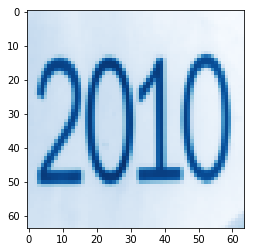

In [113]:
image_example = get_image('new', '3.png')

print("Image size: ", image_example[0].shape)
print("Image label: ", image_example[2])
print('\nExample of image preprocessing')
plt.imshow(image_example[1], cmap=plt.cm.Blues);

In [114]:
hide_code

new_images1 = np.array([get_image('new', x)[0] for x in new_filenames])
new_images2 = np.array([get_image('new', x)[1] for x in new_filenames])

In [116]:
hide_code

pickle_file = 'new_digits.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {'new_images1': new_images1, 'new_images2': new_images2,
            'new_labels': new_labels, 'new_filenames': new_filenames}
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1311730


In [120]:
hide_code

pickle_file = 'new_digits.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    new_images1 = save['new_images1']
    new_images2 = save['new_images2']
    new_labels = save['new_labels']
    new_filenames = save['new_filenames']
    del save
    
print('Number of new images: ', len(new_images1))


Number of new images:  10


In [128]:
hide_code

new_labels_cat = digit_to_categorical(new_labels)
print('The sixth dataset')
print("Shape of the features - {}, shape of the target - {}".\
      format(new_images1.shape, new_labels_cat.shape))

The sixth dataset
Shape of the features - (10, 64, 64, 3), shape of the target - (10, 5, 10)


Label:  [ 0.  0.  7.  8.  9.]
Categorical label: 
 [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]

Example of loaded images


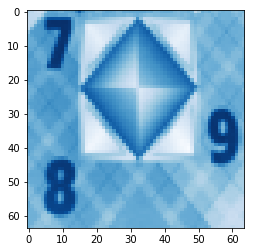

In [137]:
hide_code

print ('Label: ', new_labels[1])
print ('Categorical label: \n', new_labels_cat[1])
print('\nExample of loaded images')
plt.imshow(new_images2[1], cmap=plt.cm.Blues);

----
## $\mathfrak {\color{#348ABD} {Step \ 3: \ Test \ a \ Model \ on \ Newly-Captured \ Images}}$

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

In [27]:
hide_code
new_images1

#

''

In [ ]:
hide_code


#

### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

### Answer 7

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

### Answer 8

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

### Answer 9

----
## $\mathfrak {\color{#348ABD} {Step \ 4: \ Explore \ an \ Improvement \ for \ a \ Model}}$

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

In [ ]:
hide_code

#

In [ ]:
hide_code

#

In [ ]:
hide_code

#

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_
### Answer 10

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

### Answer 11

----
## $\mathfrak {\color{#348ABD} {Optional \ Step \ 5: \ Build \ an \ Application \ or \ Program \ for \ a \ Model}}$
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

In [ ]:
hide_code

#

In [ ]:
hide_code


#

In [ ]:
hide_code


#

### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

In [ ]:
hide_code


#